# 3 Cell feature analysis

3.1 Cell segmentation using Cellpose 2.0
3.2 Extraction of cell features using scikit-image
3.3 Dimensionality Reduction and Leiden Clustering of cell features
3.4 Nuclei displacement polarity

In [1]:
import numpy as np
from skimage.io import imread
import imageio.v2 as iio
import matplotlib.pyplot as plt
import skimage
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
import matplotlib.patches as patches
from skimage.measure import label, regionprops_table

In [2]:
# Define main path
path = '/Users/olyssa/Desktop/BA_data/'

## 3.1 Cell segmentation using Cellpose 2.0

In [ ]:
from cellpose import models
from cellpose.io import imread

In [3]:
# Define the model
model = models.CellposeModel(gpu=True, model_type="cyto")

# Original image at t = 0 h
img_stack = iio.imread(path+'/005023_hyperstack_drift_corrected_cyto_MIST_cut.tif')
img = img_stack[0]

# Get cell masks
output = model.eval(img)

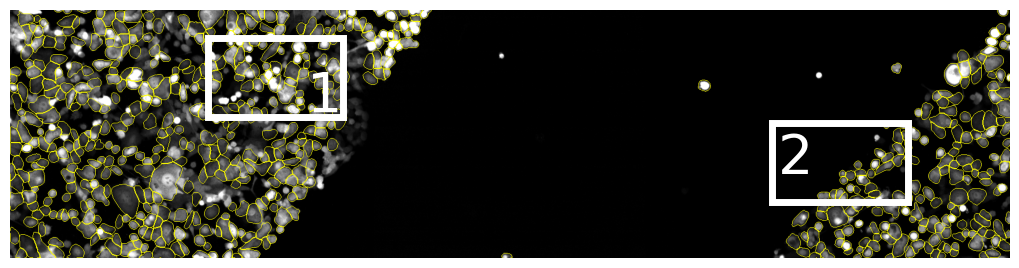

In [4]:
# Plot segmented outlines of cells
fig, ax = plt.subplots(figsize=(10.3, 2.8))
plt.imshow(mark_boundaries(image=rescale_intensity(img, in_range=(np.percentile(img, 1), np.percentile(img, 99))),
                           label_img=output[0]))
ax.set_axis_off()
fig.tight_layout()

regions = [
    (1350, 200, 140, 240),
    (350, 50, 140, 240)
]

for r_id, region in enumerate(regions):
    xr, yr, h, w = region

    ax.add_artist(
        patches.Rectangle((xr, yr), w, h, color="white", fill=False, linewidth=5)
    )
ax.text(525, 180, f'1', color="white", fontsize=40)
ax.text(1360, 290, f'2', color="white", fontsize=40)
plt.show()

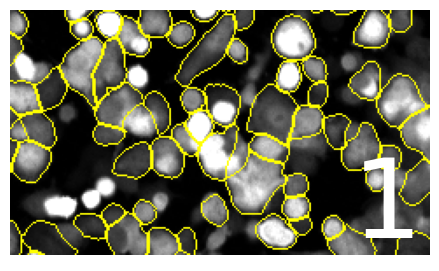

In [5]:
# Plot region 1
xr, yr, h, w = (350, 50, 140, 240)
fig = plt.figure(figsize=(4.6, 2.8))
ax = fig.gca()

img = mark_boundaries(image=rescale_intensity(img, in_range=(np.percentile(img, 1), np.percentile(img, 99))), label_img=output[0])
img_region_1 = img[yr:yr + h, xr:xr + w]
plt.imshow(img_region_1)
ax.text(195, 130, f'1', color="white", fontsize=80)
ax.set_axis_off()
fig.tight_layout()
plt.show()

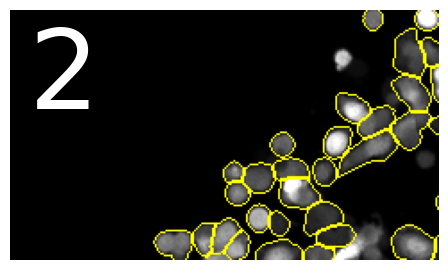

In [6]:
# Plot region 2
xr, yr, h, w = (1350, 200, 140, 240)
fig = plt.figure(figsize=(4.6, 2.8))
ax = fig.gca()

img = mark_boundaries(image=rescale_intensity(img, in_range=(np.percentile(img, 1), np.percentile(img, 99))), label_img=output[0])
img_region_1 = img[yr:yr + h, xr:xr + w]
plt.imshow(img_region_1)
ax.text(10, 55, f'2', color="white", fontsize=80)
ax.set_axis_off()
fig.tight_layout()
plt.show()

## 3.2 Extraction of cell features

In [18]:
import pandas as pd
import skimage.measure
from imageio.v2 import imread
import numpy as np
from skimage.segmentation import clear_border
from cell_features import get_cell_features, add_extra_properties, add_feature_columns

In [ ]:
# Define an example knockdown
exp_nr = 1
knockdown_nr = '005023'

img_stack = imread(uri=path+f'img_stacks_cut/exp{exp_nr}_imgs_cut/{knockdown_nr}_hyperstack_drift_corrected_cyto_MIST_cut.tif')
mask_stack = imread(uri=path+f"masks_drift_corrected/exp{exp_nr}_masks/masks_stack_{knockdown_nr}_exp{exp_nr}_cyto_cut.tif")
nuc_mask_stack = imread(uri=path+f"masks_drift_corrected/exp{exp_nr}_masks/masks_stack_{knockdown_nr}_exp{exp_nr}_nuc_cut.tif")
    
for t in range(17):
    img = img_stack[t]
    mask = mask_stack[t]
    mask = clear_border(mask)
    mask_nuc = nuc_mask_stack[t]
    mask_nuc = clear_border(mask_nuc)

    # Create df and get standard cell features
    timepoint, df = get_cell_features(t, img, mask)
    df = pd.DataFrame(df)
    df['timepoint'] = t
    
    # Add extra properties
    extra_properties = add_extra_properties(mask)
    extra_properties = pd.DataFrame(extra_properties)
    extra_properties = extra_properties.T
    df['convexity'] = extra_properties[0]
    df['form_factor'] = extra_properties[1]
    df['circularity'] = extra_properties[2]
    df['aspect_ratio'] = extra_properties[3]
    df['perimeter_curl'] = extra_properties[4]
    df['roundness'] = extra_properties[5]
    df['inscribed_area'] = extra_properties[6]
    df['sphericity'] = extra_properties[7]
    df['curl'] = extra_properties[8]
    df['concavity'] = extra_properties[9]
    df['protrusion'] = extra_properties[10]

    # Add nuclei centroid properties
    centroids_nuc = pd.DataFrame(skimage.measure.regionprops_table(mask, mask_nuc, properties=['label', 'centroid', 'intensity_mean', 'image_intensity']))
    nuclear_df = pd.DataFrame(skimage.measure.regionprops_table(mask_nuc, properties=['label', 'centroid', "area"]))

    def get_largest_nucleus_label(image_intensity):
        nuclear_labels = np.unique(image_intensity[np.where(image_intensity > 0)])
        if len(nuclear_labels) > 0:
            return int(nuclear_df.loc[nuclear_df.label.isin(nuclear_labels), ["label", "area"]].sort_values(by="area", ascending=False).iloc[0]["label"])
        else:
            return np.nan

    centroids_nuc["no_nuclei"] = centroids_nuc["image_intensity"].apply(lambda x: len(np.unique(x[np.where(x > 0)])))
    centroids_nuc["nuclear_label"] = centroids_nuc["image_intensity"].apply(get_largest_nucleus_label)
    combined_df_nuc = centroids_nuc.merge(nuclear_df, left_on="nuclear_label", right_on="label", suffixes=("", "_nuc"), how="left").drop(
        columns=["image_intensity", "area", "label_nuc", "nuclear_label",
                 "intensity_mean", "no_nuclei", 'centroid-0', 'centroid-1'])

    df = df.merge(combined_df_nuc, on="label", how="left")
    
    # Add properties about position of cells ('inside_scratch', 'at_border_left', 'at_border_right', 'bulk_left', 'bulk_right', 'distance_field')
    df_complete = add_feature_columns(exp_nr, knockdown_nr, t, img, df)
    
# Save the complete df 
pd.DataFrame.to_csv(self=df_complete, path_or_buf=path+f'/feature_tables/feature_tables_exp{exp_nr}/df_data_{knockdown_nr}_exp{exp_nr}_{t}.csv')

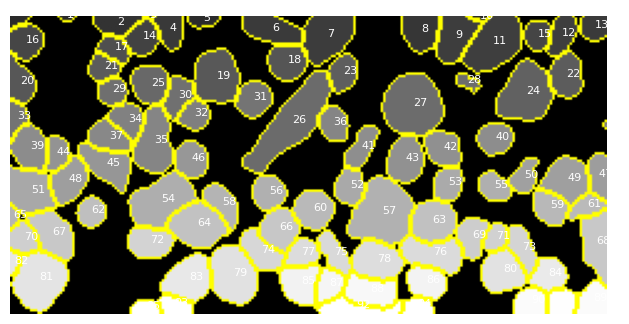

In [87]:
# Plot cell masks with labels
xr, yr, h, w = (350, 30, 120, 240)
mask = imread(path+f"/masks_stack_005023_exp1_cyto_cut.tif")[0][yr:yr + h, xr:xr + w]
labeled_image = label(mask)
cell_features = regionprops_table(labeled_image, properties = ['label', 'centroid',])
fig, ax = plt.subplots()
plt.imshow(mark_boundaries(image = rescale_intensity(mask,
                                                   in_range = (np.percentile(mask,1),
                                                               np.percentile(mask,99))),
                         label_img = mask))

for i in range(1,len(cell_features['label'])):
    plt.text(x=cell_features['centroid-1'][i],
             y=cell_features['centroid-0'][i],
             s=f'{i}', color='white', fontsize=8)

ax.set_axis_off()
fig.tight_layout()
plt.show()

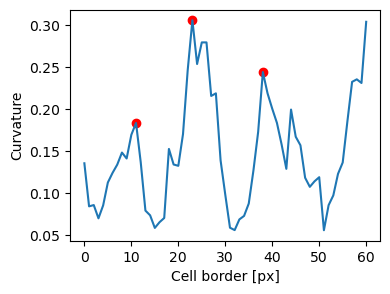

In [92]:
# Plot curvature along border for cell 26 and display protrusions

from compute_curvature import plot_edges_with_curvature, compute_real_curvature_values
from scipy.signal import argrelextrema

mask1 = (labeled_image == 26).astype(int)
real_curvature_values = compute_real_curvature_values(mask1, 20, 5)

protrusions = argrelextrema(real_curvature_values, np.greater, order=5)
ax, fig = plt.subplots(figsize=(4,3))
plt.plot(range(len(real_curvature_values)), real_curvature_values)
plt.scatter(protrusions, [real_curvature_values[i] for i in protrusions], c='red')
plt.xlabel('Cell border [px]')
plt.ylabel('Curvature')
plt.show()

## 3.3 Dimensionality Reduction and Leiden Clustering of cell features

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from knockdown_nrs import knockdown_nrs
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
import scanpy

In [ ]:
# Import data
data_exp1 = pd.read_csv(path+f'df_data_all_knockdowns_exp1_t16.csv')

In [ ]:
# Define features 
features = ['area',
            'axis_major_length',
            'axis_minor_length',
            'eccentricity',
            'equivalent_diameter_area',
            'extent',
            'feret_diameter_max',
            'orientation',
            'perimeter',
            'perimeter_crofton',
            'solidity',
            'convexity',
            'form_factor',
            'circularity',
            'aspect_ratio',
            'perimeter_curl',
            'roundness',
            'inscribed_area',
            'sphericity',
            'curl',
            'concavity',
            'protrusion',
            ]

In [ ]:
# Filtering
data_exp1_f = data_exp1[(data_exp1['area'] >= 10) &
                        (data_exp1['area'] <= 1500) &
                        #(data_exp1['form_factor'] <= 0.1) &
                        (data_exp1['circularity'] <= 1.5) &
                        (data_exp1['roundness'] <= 1.5) &
                        (data_exp1['convexity'] <= 1.03) &
                        (data_exp1['convexity'] >= 0.97) &
                        (data_exp1['protrusion'] <= 10) &
                        (data_exp1['inscribed_area'] <= 1500)]

In [ ]:
# Sampling
sample_1 = data_exp1_f.sample(frac=0.001)
x_exp1 = sample_1[features]
counts = sample_1.groupby("knockdown_nr").size()
mean = counts.mean()
std = counts.std()

counts = counts.reset_index()

dead_exp1 = sample_1["knockdown_nr"].isin(counts.loc[(counts[0] < (mean-std)) |
                                                     (counts[0] > (mean+std)), "knockdown_nr"])

data_ff = sample_1.loc[~dead_exp1]

# More preprocessing
data_ff = data_ff.fillna(0)
data_ff = data_ff.replace(-np.inf, 0)
data_ff = data_ff.replace(np.inf, 0)

df_knockdowns = pd.read_excel('plate_map_knock_down_nrs.xlsx')
df_knockdowns['knock_down_nr'] = knockdown_nrs
knockdown_symbols = df_knockdowns['Gene Symbol']

for k in range(len(knockdown_nrs)):
    data_ff.loc[data_ff['gene_symbol'] == knockdown_symbols[k], 'knockdown_numero'] = k
    
# Define x and y for umap
sample = data_ff.sample(frac=1)
x = sample[features]
y = sample['knockdown_numero']

# Scaling x
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = np.where(x_scaled > 0.25, x_scaled, 0)

# norm = plt.Normalize(y.min(), y.max())
labels = list(df_knockdowns['Gene Symbol'])

In [ ]:
# Calculate umap and leiden clusters
F = np.sum(x_scaled == 0, axis=1) / x_scaled.shape[1] <= 0.9

print(f"removed {(1-np.where(F)[0].shape[0]/len(x_scaled))*100:.2f} % of cells")

x_scaled_f = x_scaled[F]

adata = scanpy.AnnData(pd.DataFrame(x_scaled_f, columns=x.columns), obs=sample[["gene_symbol",
                                                                                "centroid-0",
                                                                                "centroid-1",
                                                                                "inside_scratch",
                                                                                "label",
                                                                                "at_border_left",
                                                                                "at_border_right"]].iloc[F])

adata = adata[adata.obs["at_border_right"] | adata.obs["at_border_left"]]

scanpy.pp.neighbors(adata, n_neighbors=10, method="rapids")
scanpy.tl.umap(adata, min_dist=0.1, method="rapids")
# scanpy.pl.umap(adata)
scanpy.tl.leiden(adata, resolution=0.2)

In [ ]:
# Plot leiden clustering
scanpy.pl.umap(adata, color=["leiden"])

# adata.write("clustering.h5ad")
x_umap = adata.obsm["X_umap"][:, 0]
y_umap = adata.obsm["X_umap"][:, 1]
fig, ax = plt.subplots()
plt.scatter(x_umap, y_umap, s=0.01)
plt.show()

## 3.4 Nuclei displacement polarity

In [4]:
from cell_features import get_border_coords

# Compute mean of linear approximations of the two leading edges
def get_border_mid(exp_nr, knockdown_nr, t):
    img_stack = imread(uri=path + f'img_stacks_cut/exp{exp_nr}_imgs_cut/{knockdown_nr}_hyperstack_drift_corrected_cyto_MIST_cut.tif')
    img = img_stack[t]
    scratch_border_left, scratch_border_right = get_border_coords(img)
    samples = np.linspace(0, 440, 100)
    line_left = np.polyfit(scratch_border_left[0], scratch_border_left[1], 1)
    line_right = np.polyfit(scratch_border_right[0], scratch_border_right[1], 1)

    border_function_left = (samples-line_left[1])/line_left[0]
    border_function_right = (samples-line_right[1]) / line_right[0]

    line_mid = (border_function_left+border_function_right)/2

    return line_mid, samples

# Calculate polarity angle of nuclei displacement towards perpendicular bisector of the scratch
def calculate_polarity_angle(exp_nr, knockdown_nr, t):
    line_mid, samples = get_border_mid(exp_nr, knockdown_nr, t)
    df = pd.read_csv(path+f'feature_tables/feature_tables_exp{exp_nr}/df_data_{knockdown_nr}_exp{exp_nr}_{t}.csv')
    df_nona = df.dropna()
    df_leading_edge = df_nona[(df_nona['at_border_left'] == 1) | (df_nona['at_border_right'] == 1)]
    df_leading_edge = df_leading_edge[(df_leading_edge['bulk_left'] == 0) & (df_leading_edge['bulk_right'] == 0)]
    df_bulk = df_nona[(df_nona['bulk_left'] == 1) | (df_nona['bulk_right'] == 1)]
    vector_scratch = [line_mid[0]-line_mid[-1], samples[0]-samples[-1]]
    polarity_angle_list = []
    polarity_angle_list_bulk = []
    for c in range(len(df_leading_edge)):
        x, y, x_nuc, y_nuc = df_leading_edge.iloc[c][["centroid-1", "centroid-0", "centroid-1_nuc", "centroid-0_nuc"]]
        vector_cell = [x_nuc-x, y_nuc-y]
        polarity = np.cos(np.dot(vector_scratch, vector_cell)/(np.linalg.norm(vector_scratch)*np.linalg.norm(vector_cell)))
        polarity_angle_list.append(polarity)

    for c in range(len(df_bulk)):
        x, y, x_nuc, y_nuc = df_bulk.iloc[c][["centroid-1", "centroid-0", "centroid-1_nuc", "centroid-0_nuc"]]
        vector_cell = [x_nuc-x, y_nuc-y]
        polarity = np.cos(
            np.dot(vector_scratch, vector_cell) / (np.linalg.norm(vector_scratch) * np.linalg.norm(vector_cell)))
        polarity_angle_list_bulk.append(polarity)

    return polarity_angle_list, polarity_angle_list_bulk